In [ ]:
#Installing relevant packages
! pip install afinn
! pip install scikit-plot
! pip install umap-learn

In [ ]:
#Importing relevant packages
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from afinn import Afinn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer 
from wordcloud import WordCloud

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist, squareform

from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import scikitplot as skplt

import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords

import spacy
from spacy import cli
from spacy import displacy
import umap.umap_ as umap

#from keybert import KeyBERT

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


#**1. Data Cleaning**

In [ ]:
#adapt file path to where your Team Project foler is (from '/Team_project...' it is the same for everyone)
data = pd.read_json('/drive/My Drive/renttherunway_final_data.json', lines=True)

#data = pd.read_json('/Users/kratikbiswari/Downloads/renttherunway_final_data.json', lines=True)

In [ ]:
data.rename(columns={'bust size': 'bust_size', 'rented for': 'rented_for', 'body type':'body_type'}, inplace=True)

In [ ]:
#Previewing data
data.sample(5)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
95400,fit,993316,34d,453349,124lbs,10.0,party,"Snug through the skirt, keep in mind if riding...",athletic,Love!,dress,"5' 4""",4,51.0,"December 5, 2015"
116822,small,416624,32d,1295171,135lbs,8.0,formal affair,Wore this for a Red Dress event and got so man...,full bust,Perfect for the Holidays!!,sheath,"5' 4""",20,47.0,"November 8, 2016"
36607,fit,732719,NaN,576000,NaN,10.0,other,"This dress...oh, this dress. It is well-made, ...",petite,I wore this for evening gown in the Mrs. Virgi...,gown,"5' 2""",12,36.0,"April 2, 2015"
111130,small,192069,32a,686884,125lbs,8.0,wedding,"True to what other people have said, this dres...",petite,Fun dress!,dress,"5' 4""",12,36.0,"September 30, 2016"
178772,fit,981572,34dd,627759,NaN,8.0,formal affair,I rented this dress for a rehearsal dinner. I ...,hourglass,I wore this for a rehearsal dinner where the b...,dress,"5' 6""",16,29.0,"October 6, 2017"


In [ ]:
data.shape

(192544, 15)

In [ ]:
data.item_id.count()

192544

In [ ]:
#Overview of dataframe structure
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust_size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented_for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body_type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


##1.1 Dealing with missing values

In [ ]:
data.isna().sum()

fit                   0
user_id               0
bust_size         18411
item_id               0
weight            29982
rating               82
rented_for           10
review_text           0
body_type         14637
review_summary        0
category              0
height              677
size                  0
age                 960
review_date           0
dtype: int64

In [ ]:
size_null = ['bust_size', 'weight', 'rented_for', 'body_type', 'height']
for i in size_null:
  i_sum = data.groupby(i).size().sort_values(ascending=False)
  print(i_sum.head(1))

bust_size
34b    27285
dtype: int64
weight
130lbs    14370
dtype: int64
rented_for
wedding    57784
dtype: int64
body_type
hourglass    55349
dtype: int64
height
5' 4"    28012
dtype: int64


In [ ]:
#bust size
data['bust_size'].fillna('34b', inplace=True)
#weight  
data['weight'].fillna('130lbs', inplace=True)
#rating
data['rating'].fillna(float(data['rating'].median()), inplace=True)
#rented for
data['rented_for'].fillna('wedding', inplace=True)
#body type 
data['body_type'].fillna('hourglass', inplace=True)
#height  
data['height'].fillna('5\' 4"', inplace=True)
#age
data['age'].fillna(float(data['age'].median()), inplace=True)

In [ ]:
data.isna().sum()

fit               0
user_id           0
bust_size         0
item_id           0
weight            0
rating            0
rented_for        0
review_text       0
body_type         0
review_summary    0
category          0
height            0
size              0
age               0
review_date       0
dtype: int64

In [ ]:
data.isna().sum().sum()

0

##1.2 Converting data type

In [ ]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['weight'] = data.weight.str.replace('lbs', '')

In [ ]:
data.head(3)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,2016-04-20
1,fit,273551,34b,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,2013-06-18
2,fit,360448,34b,1063761,130,10.0,party,This hugged in all the right places! It was a ...,hourglass,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,2015-12-14


In [ ]:
data['bust_size'].unique()

array(['34d', '34b', '34c', '32b', '34d+', '36d', '36a', '32d+', '36c',
       '32c', '32dd', '30dd', '32d', '36b', '34a', '34dd', '40ddd/e',
       '32a', '38d+', '38c', '34ddd/e', '38a', '38b', '38d', '36ddd/e',
       '38dd', '38f', '42dd', '36dd', '40g', '40dd', '28f', '30ddd/e',
       '32ddd/e', '28b', '36d+', '40d', '28dd', '34f', '42c', '30d',
       '30b', '42d', '34aa', '32aa', '36f', '28c', '40b', '36aa', '34g',
       '32f', '42ddd/e', '40c', '28g', '28aa', '36g', '30a', '44ddd/e',
       '30c', '30aa', '44dd', '32i', '32g', '30g', '38h', '30h', '34j',
       '38ddd/e', '32h', '28a', '44d', '40h', '38g', '34h', '36j', '40f',
       '36h', '28ddd/e', '44f', '34i', '30f', '36i', '30i', '28h', '42b',
       '42j', '32j', '46c', '48d', '38aa', '38i', '48dd', '28d', '28i',
       '46ddd/e', '42g', '44c', '42f', '40j', '38j', '46f', '44b', '44g',
       '42h', '40i', '44h'], dtype=object)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             192544 non-null  object        
 1   user_id         192544 non-null  int64         
 2   bust_size       192544 non-null  object        
 3   item_id         192544 non-null  int64         
 4   weight          192544 non-null  object        
 5   rating          192544 non-null  float64       
 6   rented_for      192544 non-null  object        
 7   review_text     192544 non-null  object        
 8   body_type       192544 non-null  object        
 9   review_summary  192544 non-null  object        
 10  category        192544 non-null  object        
 11  height          192544 non-null  object        
 12  size            192544 non-null  int64         
 13  age             192544 non-null  float64       
 14  review_date     192544 non-null  dat

In [ ]:
data['weight'] = data['weight'].astype('float64')

In [ ]:
def feet_to_float(cell_string):
    try:
        split_strings = cell_string.replace('"','').replace("'",'').split()
        float_value = float(split_strings[0])*12+float(split_strings[1])
    except:
        float_value = np.nan
    return float_value

In [ ]:
data['height'] = data['height'].apply(feet_to_float)

In [ ]:
data = data[data.age <= 100]
data = data[data['size'] <= 22]

In [ ]:
data.reset_index(drop=True,inplace= True)

In [ ]:
data.height

0         68.0
1         66.0
2         65.0
3         69.0
4         68.0
          ... 
171123    69.0
171124    61.0
171125    68.0
171126    66.0
171127    66.0
Name: height, Length: 171128, dtype: float64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171128 entries, 0 to 171127
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   fit             171128 non-null  object        
 1   user_id         171128 non-null  int64         
 2   bust_size       171128 non-null  object        
 3   item_id         171128 non-null  int64         
 4   weight          171128 non-null  float64       
 5   rating          171128 non-null  float64       
 6   rented_for      171128 non-null  object        
 7   review_text     171128 non-null  object        
 8   body_type       171128 non-null  object        
 9   review_summary  171128 non-null  object        
 10  category        171128 non-null  object        
 11  height          171128 non-null  float64       
 12  size            171128 non-null  int64         
 13  age             171128 non-null  float64       
 14  review_date     171128 non-null  dat

In [ ]:
data.sample(3)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
109115,fit,924382,34c,152836,125.0,8.0,formal affair,Wore this to my sorority formal and got tons o...,petite,Got tons of compliments on this one! Everyone ...,mini,62.0,12,26.0,2013-04-20
88962,large,462822,34b,1570915,135.0,8.0,work,Love the classic look and quality material. Bu...,hourglass,"Pretty dress, great for the office, but WAY ov...",dress,64.0,12,32.0,2016-03-17
114393,fit,136644,34b,2548337,131.0,10.0,other,Wore this to a daytime wine festival with jean...,hourglass,So many compliments!,top,64.0,16,43.0,2016-05-08


#**2. Exploratory Data Analysis**

In [ ]:
data.drop(columns=['rented_for','review_text','body_type','review_summary','category'])

,fit,user_id,bust_size,item_id,weight,rating,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10.0,68.0,14,28.0,2016-04-20
1,fit,273551,34b,153475,132.0,10.0,66.0,12,36.0,2013-06-18
2,fit,909926,34c,126335,135.0,8.0,65.0,8,34.0,2014-02-12
3,fit,151944,34b,616682,145.0,10.0,69.0,12,27.0,2016-09-26
4,fit,734848,32b,364092,138.0,8.0,68.0,8,45.0,2016-04-30
...,...,...,...,...,...,...,...,...,...,...
171123,fit,66386,34dd,2252812,140.0,10.0,69.0,8,42.0,2016-05-18
171124,fit,118398,32c,682043,100.0,10.0,61.0,4,29.0,2016-09-30
171125,fit,47002,36a,683251,135.0,6.0,68.0,8,31.0,2016-03-04
171126,fit,961120,36c,126335,165.0,10.0,66.0,16,31.0,2015-11-25


In [ ]:
print(data['fit'].unique())
print(len(data['body_type'].unique()))
print(len(data['category'].unique()))

['fit' 'small' 'large']
7
68


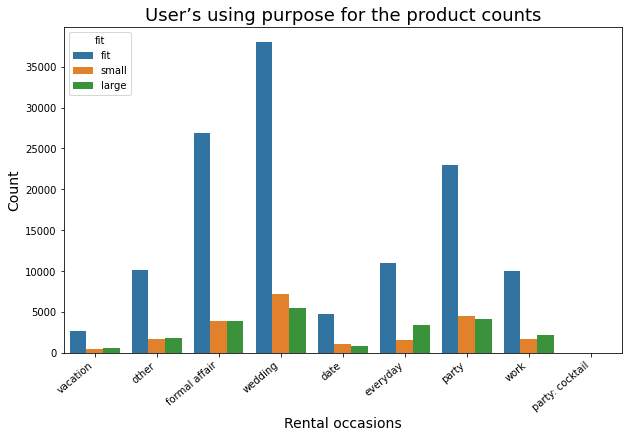

In [ ]:
plt.figure(figsize=(10,6))
a=sns.countplot(data=data,x='rented_for',hue='fit')
a.set_xticklabels(a.get_xticklabels(), rotation=40, ha="right")
plt.title('User’s using purpose for the product counts', size = 18)
plt.xlabel('Rental occasions', size = 14)
plt.ylabel('Count', size = 14)
plt.show()

From the graph above, we can see that most people rent clothes for weddings and formal affairs. Across all the renting purposes, most people found the size that fits their body. 


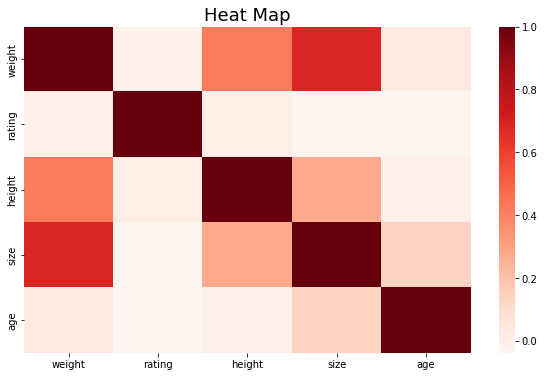

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(data.drop(['user_id','item_id'],axis=1).corr(),cmap='Reds')
plt.title('Heat Map', size = 18)
plt.show()

We observed that the size of clothes is correlated with the user's weight and height based on the graph above. Especially weight, it has a significant positive correlation with the size of the clothes. Thus, we want to compare the user's weight and the clothing size they chose.


In [ ]:
data.describe()

,user_id,item_id,weight,rating,height,size,age
count,171128.000000,1.711280e+05,171128.000000,171128.000000,171128.000000,171128.000000,171128.000000
mean,498976.275414,1.067368e+06,132.791717,9.103969,65.223435,10.119805,33.545457
std,289591.388352,8.130746e+05,15.298126,1.422536,2.633416,5.742950,7.714472
min,9.000000,1.233730e+05,50.000000,2.000000,54.000000,0.000000,0.000000
25%,249023.250000,2.109045e+05,125.000000,8.000000,63.000000,4.000000,29.000000
50%,499439.000000,9.790160e+05,130.000000,10.000000,65.000000,8.000000,32.000000
75%,751151.750000,1.695878e+06,140.000000,10.000000,67.000000,14.000000,37.000000
max,999997.000000,2.966087e+06,250.000000,10.000000,78.000000,22.000000,100.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


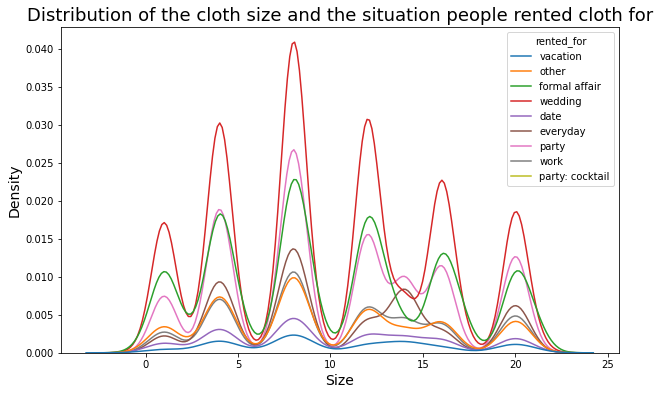

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=data,x='size',hue='rented_for')
plt.title('Distribution of the cloth size and the situation people rented cloth for', size = 18)
plt.xlabel('Size', size = 14)
plt.ylabel('Density', size = 14)
plt.show()

The graph from above shows the distribution of the cloth size and the situation people rented cloth for. We can notice that most sizes falls into the range between 5 and 15 for all purposes. 

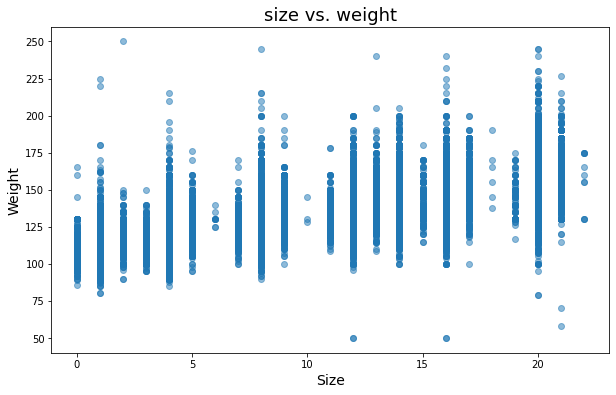

In [ ]:
#Size is most relevent to weight and height.
plt.figure(figsize=(10,6))
plt.scatter(x='size',y='weight', data=data, alpha=0.5)
plt.title('size vs. weight', size = 18)
plt.xlabel('Size', size = 14)
plt.ylabel('Weight', size = 14)
plt.show()

Illustrated by the graph from above, the x-axis represents the size and the y-axis represents the weight, we see there is a clear positive correlation, which makes sense since people who have more weight usually buy larger clothes

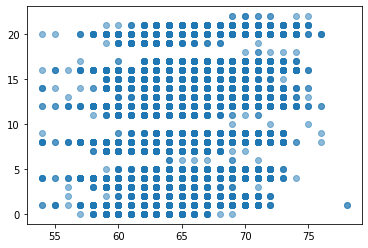

In [ ]:
plt.scatter('height', 'size', data=data, alpha=0.5)
plt.show()

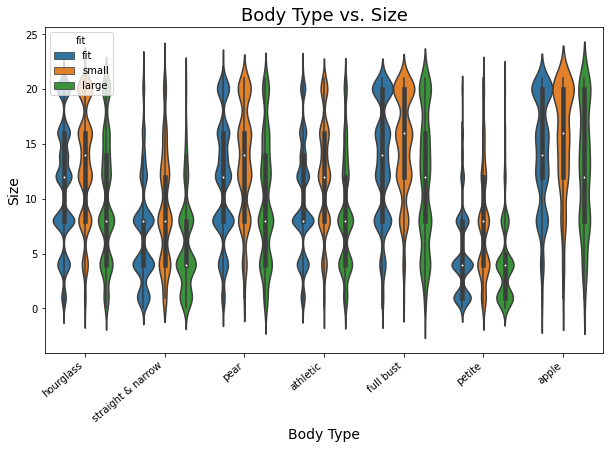

In [ ]:
plt.figure(figsize=(10,6))
b=sns.violinplot(x='body_type',y='size',data=data,hue='fit')
b.set_xticklabels(b.get_xticklabels(), rotation=40, ha="right")
plt.title('Body Type vs. Size', size = 18)
plt.xlabel('Body Type', size = 14)
plt.ylabel('Size', size = 14)
plt.show()

Based on the plot above, we can conclude that most people in this dataset have a body type of full bust and apple. Except for people with straight & narrow and petite body types who will choose a smaller size, there is not much difference in the clothing size between other body types. 


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


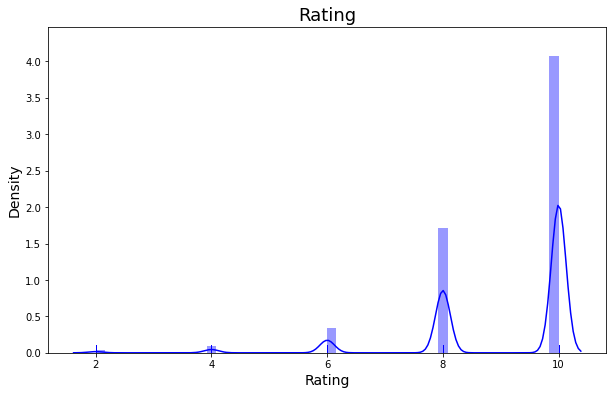

In [ ]:
#most of the clothes are betwen size 0 to 30, whatever the type it is.
plt.figure(figsize=(10,6))
sns.distplot(data['rating'], color="b", rug=True)
plt.title('Rating', size = 18)
plt.xlabel('Rating', size = 14)
plt.ylabel('Density', size = 14)
plt.show()

#**3. Analytical Findings**


## 3.1 Text Analysis

Checking All Reviews Column

In [ ]:
tdv = TfidfVectorizer()
tdv.fit(data.review_summary)
tdm = tdv.transform(data.review_summary)
tdv.vocabulary_

{'so': 9184,
 'many': 6129,
 'compliments': 2331,
 'felt': 3838,
 'glamourous': 4468,
 'dress': 3185,
 'arrived': 767,
 'on': 6954,
 'time': 10154,
 'and': 625,
 'in': 5184,
 'perfect': 7329,
 'condition': 2363,
 'was': 10897,
 'love': 5962,
 'with': 11117,
 'this': 10084,
 'traditional': 10273,
 'touch': 10249,
 'sass': 8525,
 'literally': 5849,
 'the': 10035,
 'cutest': 2693,
 'ever': 3566,
 'great': 4624,
 'beautifully': 1133,
 'made': 6058,
 'received': 8024,
 'lots': 5947,
 'of': 6902,
 'for': 4122,
 'black': 1288,
 'tie': 10129,
 'event': 3562,
 'everything': 3579,
 'it': 5357,
 'masquerade': 6187,
 'ball': 996,
 'we': 10933,
 'attended': 842,
 'fun': 4261,
 'to': 10181,
 'wear': 10936,
 'wouldn': 11199,
 'normally': 6802,
 'buy': 1687,
 'stunning': 9653,
 'new': 6714,
 'year': 11261,
 'eve': 3558,
 'wedding': 10957,
 'me': 6241,
 'feel': 3825,
 'confident': 2377,
 'sexy': 8764,
 'ordered': 7017,
 'as': 785,
 'replacement': 8181,
 'gown': 4579,
 'wore': 11161,
 'heart': 4815,
 'a

In [ ]:
#sentiment scores for summary_reviews
afinn=Afinn()
#afinn = afinn.Afinn()
lis =[]
for i in data.review_summary:
    sc = afinn.score(i)
    lis.append(sc)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


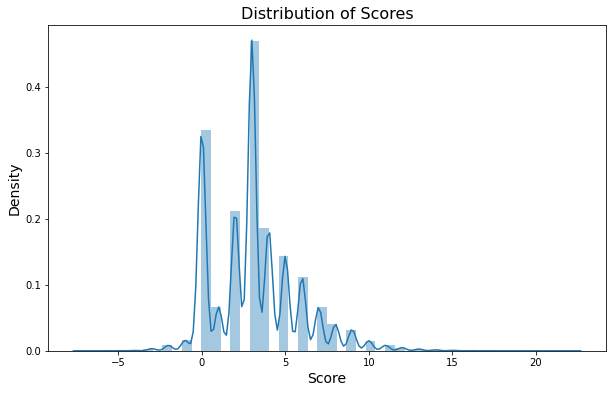

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(lis)
plt.title('Distribution of Scores', size = 16)
plt.xlabel('Score', size = 14)
plt.ylabel('Density', size = 14)
plt.show()

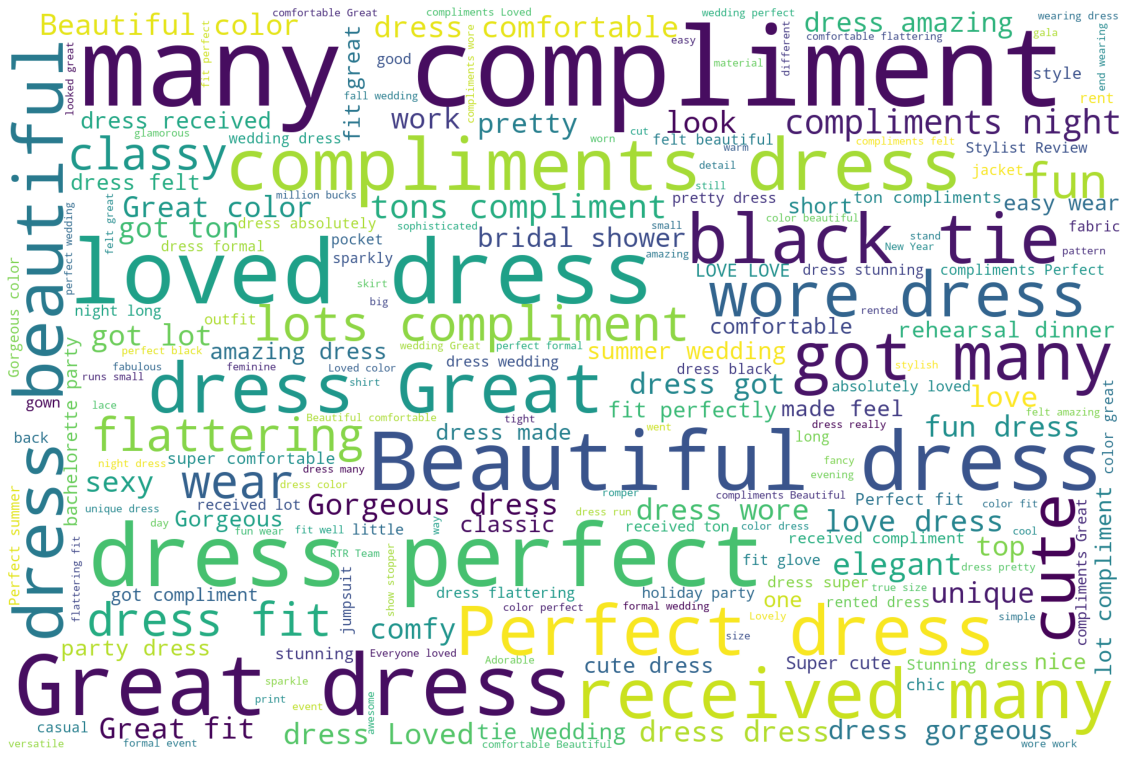

In [ ]:
#All comments
plt.figure(figsize=(20,16))
wc = WordCloud(background_color="white", width=1800, height=1200)
st = ''
for i in data.review_summary:
    st+= i
wordcloud = wc.generate(st)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
data2=data
data2['sent']=lis

In [ ]:
data2_good=data2.loc[data2['sent']>5]
data2_bad=data2.loc[data2['sent']<0]
data2_good.sample(2)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date,sent
64201,fit,593893,38d,1859039,130.0,10.0,date,"It was short on me, but the coverage on top he...",hourglass,I wore this dress on a date night to a Smokey ...,dress,67.0,20,38.0,2016-01-24,6.0
52130,fit,292442,32b,1665666,150.0,10.0,other,"Chest is meant for bigger breasts, so may requ...",straight & narrow,"I wore this for graduation, and it was a great...",maxi,70.0,13,32.0,2017-05-26,6.0


In [ ]:
nltk.download('stopwords') 
STOPWORDS = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


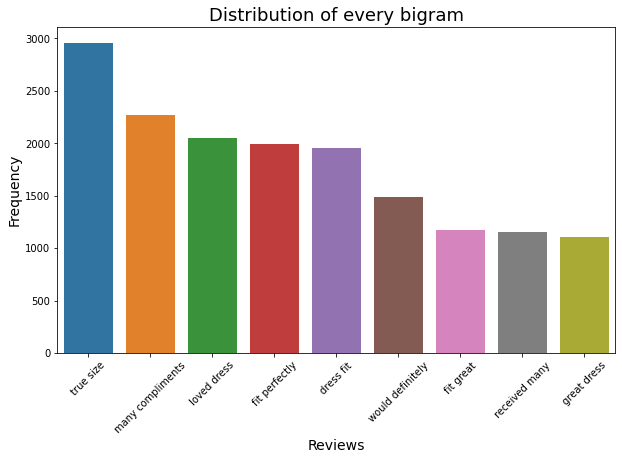

In [ ]:
#good comments
plt.figure(figsize=(10,6))
cv = CountVectorizer(ngram_range=(2,2),stop_words=STOPWORDS)
tokens = cv.fit_transform(data2_good['review_text'])

sum_words = tokens.sum(axis=0)
words_freq = [[word, sum_words[0, idx]] for word, idx in cv.vocabulary_.items()]
sorted(words_freq, key = lambda x: x[1], reverse=True)[:10]

good_comm=pd.DataFrame()
bigram=[]
freq=[]
for i in words_freq:
  bigram.append(i[0])
  freq.append(i[1])

good_comm['bigram']=bigram
good_comm['freq']=freq

good_comm.sort_values(by='freq',ascending=False,inplace=True)

good_comm_sub=good_comm.iloc[0:9]
sns.barplot(x='bigram',y='freq',data=good_comm_sub)
plt.xticks(rotation=45)
plt.title('Distribution of every bigram', size = 18)
plt.xlabel('Reviews', size = 14)
plt.ylabel('Frequency', size = 14)
plt.show()

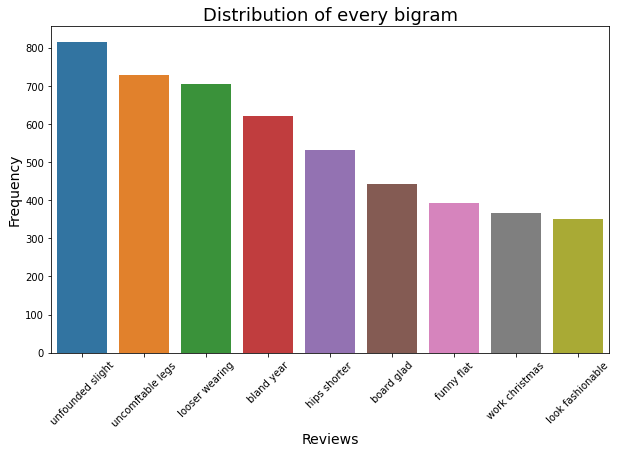

In [ ]:
#bad comments
plt.figure(figsize=(10,6))
cv2 = CountVectorizer(ngram_range=(2,2),stop_words=STOPWORDS)
tokens2 = cv2.fit_transform(data2_bad['review_text'])

sum_words2 = tokens2.sum(axis=0)
words_freq2 = [[word, sum_words[0, idx]] for word, idx in cv2.vocabulary_.items()]

bad_comm=pd.DataFrame()
bigram2=[]
freq2=[]
for i in words_freq2:
  bigram2.append(i[0])
  freq2.append(i[1])

bad_comm['bigram']=bigram2
bad_comm['freq']=freq2

bad_comm.sort_values(by='freq',ascending=False,inplace=True)

bad_comm_sub=bad_comm.iloc[0:9]
sns.barplot(x='bigram',y='freq',data=bad_comm_sub)
plt.xticks(rotation=45)
plt.title('Distribution of every bigram', size = 18)
plt.xlabel('Reviews', size = 14)
plt.ylabel('Frequency', size = 14)
plt.show()

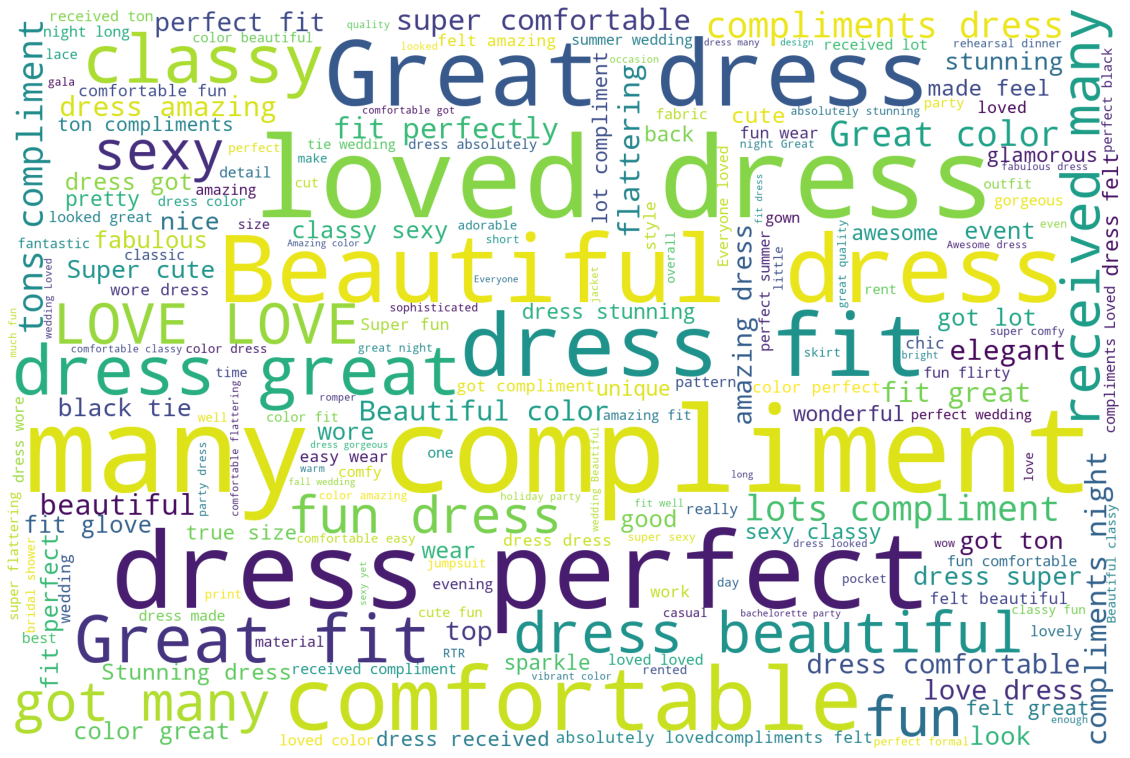

In [ ]:
plt.figure(figsize=(20,16))
wc = WordCloud(background_color="white", width=1800, height=1200)
st = ''
for i in data2_good.review_summary:
    st+= i
wordcloud = wc.generate(st)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

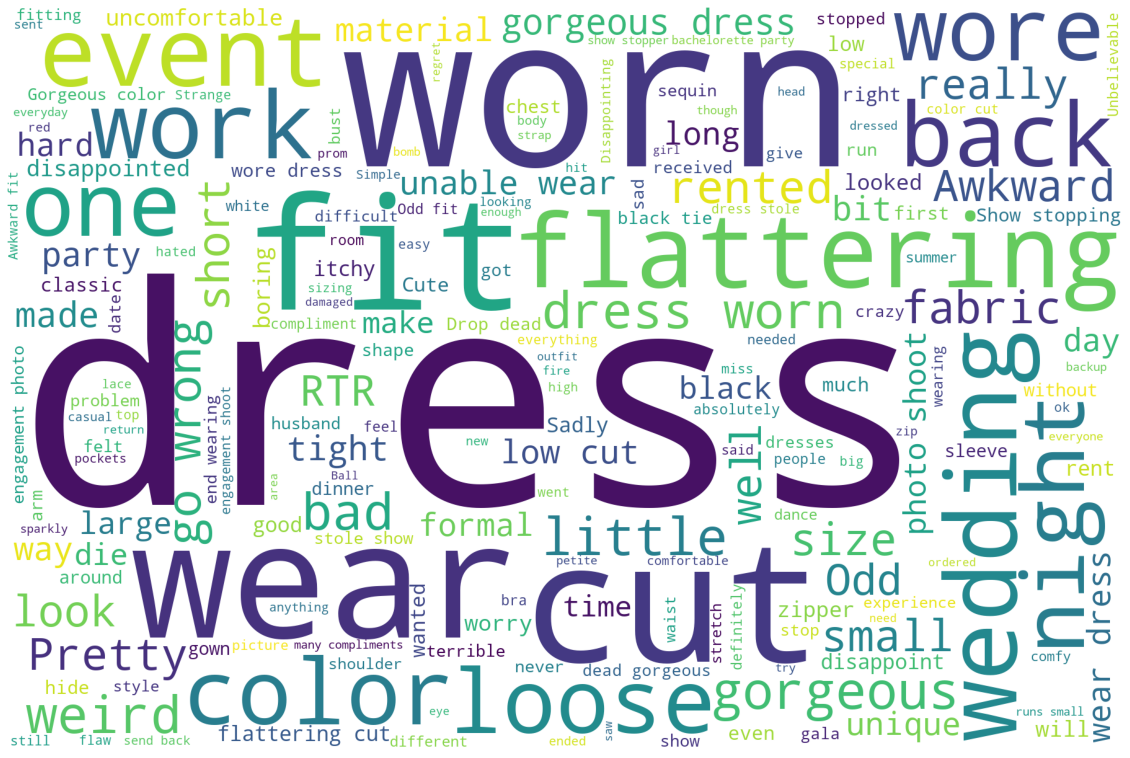

In [ ]:
plt.figure(figsize=(20,16))
wc = WordCloud(background_color="white", width=1800, height=1200)
st = ''
for i in data2_bad.review_summary:
    st+= i
wordcloud = wc.generate(st)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
model = "en_core_web_md"
cli.download(model)

nlp = spacy.load(model)

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
data2_good.sent.describe()

count    28195.000000
mean         7.477638
std          1.773820
min          6.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         22.000000
Name: sent, dtype: float64

In [ ]:
corpus=[]
for words in data2_good['review_text']:
  corpus.append(words)

In [ ]:
doc=list(nlp.pipe(corpus))
#doc

## 3.2 Clustering Analysis


### 3.2.1 One-Hot Encoding and PCA

In [ ]:
data_dummified = pd.get_dummies(data, columns=['bust_size', 'body_type'])

In [ ]:
data_dummified.shape

(171128, 104)

In [ ]:
data_num = data_dummified.drop(columns=['fit','user_id','item_id','rating','rented_for','review_text','review_summary','size','review_date','category'], axis=1)
sc = StandardScaler()
data_scaled = sc.fit_transform(data_num)
pca = PCA()
pcs = pca.fit_transform(data_scaled)

In [ ]:
data_clust = pd.DataFrame(pcs[:,:80], columns=['pc'+str(i) for i in range(1,81)])
data_sample = data_clust.sample(25000, random_state=820)

#### Profiling the Clusters

### 3.2.2 K-Means Clustering

Vectorizing the Review Summary

In [ ]:
nlp = spacy.load('en_core_web_md')


In [ ]:
data_dummified_2 = pd.get_dummies(data= data_dummified, columns=['rented_for',"category"])

In [ ]:
data_kmeans = data_dummified_2.drop(['user_id','fit','review_text',"item_id",'review_date'],axis=1)

In [ ]:
data_kmeans.shape

(171128, 174)

In [ ]:
tk = [nlp(i).vector for i in list(data_kmeans.review_summary)]
d2 = pd.DataFrame(np.array(tk), columns=[i for i in range(0,300)])
d2.shape

(171128, 300)

In [ ]:
data_txt = data_kmeans.join(d2, how = 'inner')
data_txt.drop("review_summary",axis=1, inplace = True)

In [ ]:
sc = StandardScaler()
data_sca = sc.fit_transform(data_txt)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
data_umap = umap.UMAP().fit_transform(data_sca)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


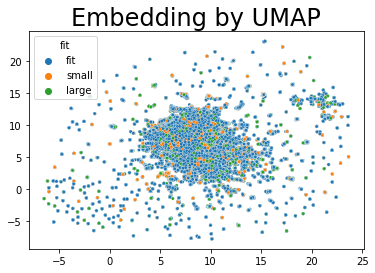

In [ ]:
sns.scatterplot(x=data_umap[:, 0],y= data_umap[:, 1],s=10,hue=data.fit)
plt.title('Embedding by UMAP', fontsize=24)
plt.show();

In [ ]:
data.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date,sent
0,fit,420272,34d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68.0,14,28.0,2016-04-20,2.0
1,fit,273551,34b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66.0,12,36.0,2013-06-18,3.0
2,fit,909926,34c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65.0,8,34.0,2014-02-12,3.0
3,fit,151944,34b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69.0,12,27.0,2016-09-26,3.0
4,fit,734848,32b,364092,138.0,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68.0,8,45.0,2016-04-30,0.0


In [ ]:
df_umap = pd.DataFrame(data_umap, columns = [i for i in range(0,2)])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklea

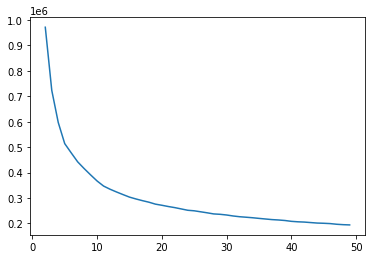

In [ ]:
inertia = []
for i in range(2,50):
    model = KMeans(n_clusters=i, random_state = 2807);
    model.fit(data_txt.sample(5000, random_state= 2807));
    pred = model.predict(data_txt.sample(5000, random_state= 2807));
    inertia.append(model.inertia_)
sns.lineplot(range(2,50), inertia)
plt.show();

In [ ]:
silo = []
for i in range(5,20):
    model = KMeans(n_clusters=i,random_state= 2807)
    model.fit(df_umap.sample(5000,random_state= 2807))
    pred = model.predict(df_umap.sample(5000, random_state= 2807))
    silo.append(metrics.silhouette_score(df_umap.sample(5000, random_state= 2807),pred))
sil = pd.DataFrame(silo, columns=['silhouette_score'])
sil['clusters'] = [i for i in range(5,20)]

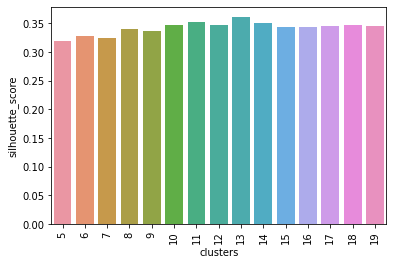

In [ ]:
sns.barplot(data = sil, y="silhouette_score", x= "clusters")
plt.xticks(rotation=90);

In [ ]:
kmean = KMeans(n_clusters= 5)
kmean.fit(data_umap)
k_5 = kmean.predict(data_umap)
len(k_5)

171128

In [ ]:
data_clustered = data.copy()
data_clustered['kmeans_5'] = k_5

In [ ]:
data_clustered.groupby('kmeans_5')['item_id'].count()

kmeans_5
0     9483
1    55194
2    11576
3    21194
4    73681
Name: item_id, dtype: int64

In [ ]:
pip install keybert
from keybert import KeyBERT
def wordcloud_keybert(text):
  wc = WordCloud(background_color="white")
  kw_model = KeyBERT();
  st = ''
  for j in text:
   foo = " ".join(j.split())
   #print(len(foo.split()))
   #print(foo)
   try:
       keywords = kw_model.extract_keywords(foo,keyphrase_ngram_range=(1, 1), stop_words='english', 
                              use_maxsum=True, nr_candidates=20, top_n=5)
       #print(keywords)
       for i in keywords:
         st += (i[0] + ' ')
   except:
       print("Erron in line")
  wordcloud = wc.generate(st)
  plt.imshow(wordcloud)
  plt.axis("off")
  return plt.show();

SyntaxError: ignored

In [ ]:
wordcloud_keybert(data_clustered[data_clustered['kmeans_5']==0].review_summary.sample(20, random_state = 5103))
wordcloud_keybert(data_clustered[data_clustered['kmeans_5']==1].review_summary.sample(20, random_state = 5103))
wordcloud_keybert(data_clustered[data_clustered['kmeans_5']==2].review_summary.sample(20, random_state = 5103))
wordcloud_keybert(data_clustered[data_clustered['kmeans_5']==3].review_summary.sample(20, random_state = 5103))
wordcloud_keybert(data_clustered[data_clustered['kmeans_5']==4].review_summary.sample(20, random_state = 5103))

Using K- Nearest Neighbours for recommendation

In [ ]:
#pivoting the data_txt data frame
data_txt_pivot = data_txt.pivot

In [ ]:
#parsing the data frame to make a sparse matrix
from scipy.sparse import csr_matrix
data_sparse = csr_matrix(data_txt)

In [ ]:
# initializing knn with brute algorithm
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(algorithm='brute')

In [ ]:
#fitting the model with sparse data
knn.fit(data_sparse)

In [ ]:
#changing the index for item id to get recommendation on item_id
data_txt.index = data['item_id']

In [ ]:
# getting distances and suggestions based on id
distances, suggestions = knn.kneighbors(data_txt.iloc[12345, :].values.reshape(1,-1), n_neighbors = 6)

In [ ]:
data[data.index == suggestions[0,0]]

In [ ]:
data[data.index == suggestions[0,4]]

In [ ]:
#recomendation for size

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=500,random_state= 820)

In [ ]:
data_rfc = data[['size','height','weight','age']]
data_rfc.head(3)

In [ ]:
X = data_rfc.drop('size',axis=1)
y = data_rfc['size']

In [ ]:
rfc.fit(X,y)

In [ ]:
def size_predict():
    age = float(input("age = "))
    weight = float(input("weight = "))
    height = float(input("height = "))
    return rfc.predict(np.array([height,weight,age]).reshape(1,3))

In [ ]:
size_predict()